In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import graphviz
import pandas_profiling
import matplotlib.pyplot as plt
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import tree
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.utils.fixes import signature

from matplotlib.legend_handler import HandlerLine2D

%matplotlib inline

Columns:
* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - 1 or 0

In [2]:
path = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
columns = ["age", "sex", "cp", 
           "trestbps", "chol", "fbs", 
           "restecg", "thalach","exang", 
           "oldpeak","slope", "ca", "thal", "num"]

data_pd = pd.read_csv(path, header=None, names=columns, na_values=['?'])
data_pd['target'] = np.where(data_pd.num > 0, 1, 0)
data_pd.drop('num', inplace=True, axis=1)

data_pd = data_pd.dropna() # 4 records

In [ ]:
pandas_profiling.ProfileReport(data_pd)

### Logistic Regression

Basic Training (train/test split)

In [3]:
X = data_pd[data_pd.columns[:-1]]
y = data_pd['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y) #default test split is 0.25 

In [4]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.76
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        40
           1       0.76      0.71      0.74        35

   micro avg       0.76      0.76      0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75

[[32  8]
 [10 25]]


/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Cross validation

In [5]:
kfold = KFold(n_splits=5, random_state=7)
modelCV = LogisticRegression()
scoring = 'accuracy'
results = cross_val_score(modelCV, X_train, y_train, cv=kfold, scoring=scoring) 
print("5-fold cross validation average accuracy: %.3f" % (results.mean()))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

5-fold cross validation average accuracy: 0.847
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        40
           1       0.76      0.71      0.74        35

   micro avg       0.76      0.76      0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75

[[32  8]
 [10 25]]


/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Defau

Grid search

In [6]:
parameters = {
    'penalty' : ['l1', 'l2'],
     'C': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(LogisticRegression(), 
                   parameters, 
                   cv=5, 
                   scoring='accuracy', 
                   refit=True,
                   return_train_score=True, 
                   n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

grid_logreg = grid_search.best_estimator_
y_pred = grid_logreg.predict(X_test)
y_proba = grid_logreg.predict_proba(X_test)[:,1]

0.8423423423423423
{'C': 0.1, 'penalty': 'l2'}


/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/Users/roma.keister/venv36_v1/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


### Metrics

Let's see a classification report and confusion matrix 

In [9]:
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[32  8]
 [10 25]]
              precision    recall  f1-score   support

           0       0.76      0.80      0.78        40
           1       0.76      0.71      0.74        35

   micro avg       0.76      0.76      0.76        75
   macro avg       0.76      0.76      0.76        75
weighted avg       0.76      0.76      0.76        75



[[32  8]
 [10 25]]


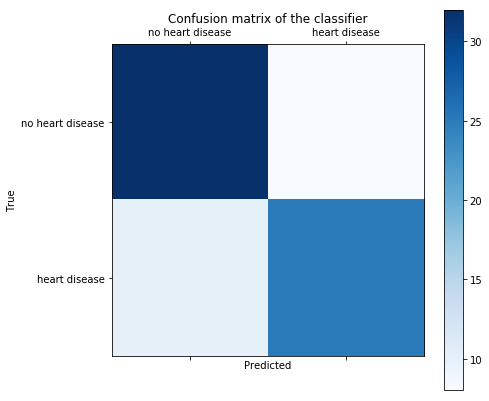

In [21]:
labels = ['no heart disease', 'heart disease']
cm = confusion_matrix(y_test, y_pred)
print(cm)
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
cax = ax.matshow(cm)
plt.title('Confusion matrix of the classifier')
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
fig.colorbar(im, ax=ax)
#fig.colorbar(im)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Let's draw a precision-recall curve for the last model, this will show a trade-off between those two
Precision - of those classified as having a heart disease, what proportion actually were having a heart disease (true positive rate)?
Recall - of those actually having a heart disease how many were classified this way (positive predictive value)?

Average precision-recall score: 0.85


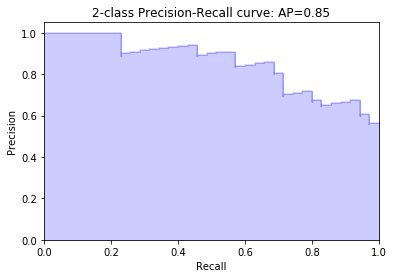

In [27]:
average_precision = average_precision_score(y_test, y_proba)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

precision, recall, _ = precision_recall_curve(y_test, y_proba)

# In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

plt.show()

Let's now draw a ROC curve. It's different from precision-recall plot as it plots a true positive rate vs false positive rate at different probability thresholds. 

AUC: 0.859


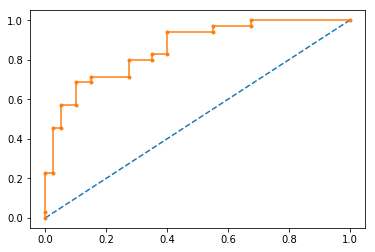

In [25]:
auc = roc_auc_score(y_test, y_proba)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

### Logistic Regression Interpretation

Coefficients

Visualization

In [33]:
perm = PermutationImportance(grid_logreg, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = data_pd.columns.tolist()[:-1])

Weight,Feature
0.0373 ± 0.0427,thal
0.0373 ± 0.0569,ca
0.0160 ± 0.0617,thalach
0.0000 ± 0.0239,age
-0.0027 ± 0.0107,fbs
-0.0027 ± 0.0107,chol
-0.0053 ± 0.0495,oldpeak
-0.0080 ± 0.0131,trestbps
-0.0080 ± 0.0272,cp
-0.0133 ± 0.0000,slope


### Decision Tree

In [ ]:
def get_auc(dt, X, y):
    y_pred = dt.predict(X)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y, y_pred)
    return auc(false_positive_rate, true_positive_rate)

def plot_parameter_search(X_train, y_train, X_test, y_test, param_values, param_name):
    train_results = []
    test_results = []

    for val in param_values:
        dt = tree.DecisionTreeClassifier(**{param_name: val})
        dt.fit(X_train, y_train)

        train_results.append(get_auc(dt, X_train, y_train))
        test_results.append(get_auc(dt, X_test, y_test))

    line1, = plt.plot(param_values, train_results, 'b', label='Train AUC')
    line2, = plt.plot(param_values, test_results, 'r', label='Test AUC')
    plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
    plt.ylabel('AUC score')
    plt.xlabel(param_name)
    plt.show()


parameters = {
    'max_depth': np.linspace(1, 10, 10, endpoint=True),
    'min_samples_leaf': np.linspace(0.01, 0.5, 20, endpoint=True),
    'min_samples_split': np.linspace(0.0001, 1.0, 20, endpoint=True),
    'max_features': list(range(1,X_train.shape[1])),
    
}
    
for param, values in parameters.items():
    plot_parameter_search(X_train, y_train, X_test, y_test, values, param)

In [ ]:
max_features = list(range(1,X_train.shape[1]))

train_results = []
test_results = []

for val in max_features:
    dt = tree.DecisionTreeClassifier(**{'max_features': val, 'max_depth': 4})
    dt.fit(X_train, y_train)

    train_results.append(get_auc(dt, X_train, y_train))
    test_results.append(get_auc(dt, X_test, y_test))

line1, = plt.plot(max_features, train_results, 'b', label='Train AUC')
line2, = plt.plot(max_features, test_results, 'r', label='Test AUC')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('AUC score')
plt.xlabel('max_features (max_depth=4)')
plt.show()

Grid Search

In [ ]:
del parameters['min_samples_split']

grid_search = GridSearchCV(tree.DecisionTreeClassifier(), 
                   parameters, 
                   cv=5, 
                   scoring='recall', 
                   refit=True,
                   return_train_score=True, 
                   n_jobs=-1)
grid_search.fit(X_train, y_train)

print(grid_search.best_score_)
print(grid_search.best_params_)

clf = grid_search.best_estimator_

Precision/Recall

In [ ]:
y_pred = clf.predict(X_train)

precision_recall_fscore_support(y_train, y_pred, average='binary')

In [ ]:
y_pred = clf.predict(X_test)

precision_recall_fscore_support(y_test, y_pred, average='binary')

### Decision Tree Interpretation

Feature importance

In [ ]:
sns.barplot(x=clf.feature_importances_, y=data_pd.columns[:-1])

Visualization

In [ ]:
dot_data = tree.export_graphviz(clf, feature_names=data_pd.columns[:-1],  
                                out_file=None, class_names=True,
                                filled=True, rounded=True)  
graphviz.Source(dot_data)  

Decision tree boundaries

More advanced interpretation techniques: